# Market Segmentation POC Demo

This notebook demonstrates the Market Segmentation system functionality including:
- Sample data generation
- Model training
- Making predictions
- Analyzing results
- Using the API

In [2]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random

# Add src to path
sys.path.append('../src')

# Import our modules
from models.data_models import (
    ContactInput, 
    CompanySize, 
    IndustryVertical, 
    JobFunction,
    BatchSegmentRequest
)
from models.segmentation import MarketSegmentationModel
from services.prediction import PredictionService
from services.feature_engineering import FeatureEngineeringService

print("✅ All imports successful!")

✅ All imports successful!


## 1. Generate Sample Data

Let's create realistic sample contact data for testing our segmentation model.

In [3]:
def generate_sample_contacts(n_contacts=500):
    """Generate sample contact data for demonstration."""
    
    contacts = []
    random.seed(42)  # For reproducible results
    
    # Define realistic distributions
    company_sizes = list(CompanySize)
    industries = list(IndustryVertical)
    job_functions = list(JobFunction)
    regions = [
        "North America", "Europe", "Asia Pacific", "Latin America", 
        "Middle East", "Africa"
    ]
    
    for i in range(n_contacts):
        # Generate correlated attributes for realistic segments
        company_size = random.choice(company_sizes)
        
        # Larger companies tend to have higher revenues
        if company_size == CompanySize.ENTERPRISE:
            base_revenue = random.uniform(1000000, 10000000)
            seniority_bias = 0.3  # More senior roles
        elif company_size == CompanySize.MID_MARKET:
            base_revenue = random.uniform(100000, 1000000)
            seniority_bias = 0.0
        else:  # SMB
            base_revenue = random.uniform(10000, 100000)
            seniority_bias = -0.2  # Less senior roles
        
        # Job function influences engagement and seniority
        job_function = random.choice(job_functions)
        
        if job_function == JobFunction.C_SUITE:
            seniority_level = random.randint(4, 5)
            engagement_bias = 0.2  # C-suite more engaged
        elif job_function == JobFunction.SALES:
            seniority_level = random.randint(2, 4)
            engagement_bias = 0.1
        else:
            seniority_level = max(1, min(5, int(random.gauss(3, 1) + seniority_bias)))
            engagement_bias = 0.0
        
        # Industry affects engagement patterns
        industry = random.choice(industries)
        if industry in [IndustryVertical.TECHNOLOGY, IndustryVertical.FINANCIAL_SERVICES]:
            engagement_bias += 0.1
        
        # Generate engagement score with realistic distribution
        base_engagement = random.gauss(0.5, 0.2)
        engagement_score = max(0.0, min(1.0, base_engagement + engagement_bias))
        
        # Some contacts don't have revenue data
        account_revenue = base_revenue if random.random() > 0.1 else None
        
        contact = ContactInput(
            contact_id=f"demo_contact_{i:04d}",
            company_size=company_size,
            industry_vertical=industry,
            job_function=job_function,
            seniority_level=seniority_level,
            geographic_region=random.choice(regions),
            engagement_score=round(engagement_score, 3),
            account_revenue=account_revenue
        )
        
        contacts.append(contact)
    
    return contacts

# Generate sample data
print("Generating sample contact data...")
sample_contacts = generate_sample_contacts(500)
print(f"✅ Generated {len(sample_contacts)} sample contacts")

# Display first few contacts
for i in range(3):
    contact = sample_contacts[i]
    print(f"\nContact {i+1}:")
    print(f"  ID: {contact.contact_id}")
    print(f"  Company: {contact.company_size.value} in {contact.industry_vertical.value}")
    print(f"  Role: {contact.job_function.value} (Level {contact.seniority_level})")
    print(f"  Engagement: {contact.engagement_score}")
    print(f"  Revenue: ${contact.account_revenue:,.0f}" if contact.account_revenue else "  Revenue: Not available")

Generating sample contact data...
✅ Generated 500 sample contacts

Contact 1:
  ID: demo_contact_0000
  Company: enterprise in manufacturing
  Role: sales (Level 3)
  Engagement: 0.655
  Revenue: $2,001,980

Contact 2:
  ID: demo_contact_0001
  Company: smb in healthcare
  Role: c_suite (Level 4)
  Engagement: 1.0
  Revenue: $63,144

Contact 3:
  ID: demo_contact_0002
  Company: enterprise in financial_services
  Role: operations (Level 2)
  Engagement: 0.296
  Revenue: $1,238,824


## 2. Explore the Data

Let's analyze our sample data to understand the distributions.

In [4]:
# Convert contacts to DataFrame for analysis
data = []
for contact in sample_contacts:
    data.append({
        'contact_id': contact.contact_id,
        'company_size': contact.company_size.value,
        'industry_vertical': contact.industry_vertical.value,
        'job_function': contact.job_function.value,
        'seniority_level': contact.seniority_level,
        'geographic_region': contact.geographic_region,
        'engagement_score': contact.engagement_score,
        'account_revenue': contact.account_revenue or 0
    })

df = pd.DataFrame(data)
print("📊 Data Overview:")
print(df.describe())
print("\n📈 Data Info:")
print(df.info())

📊 Data Overview:
       seniority_level  engagement_score  account_revenue
count       500.000000        500.000000     5.000000e+02
mean          2.834000          0.563396     1.958663e+06
std           1.103122          0.211975     2.990516e+06
min           1.000000          0.000000     0.000000e+00
25%           2.000000          0.415000     5.440456e+04
50%           3.000000          0.559500     3.866043e+05
75%           4.000000          0.714250     2.914698e+06
max           5.000000          1.000000     9.996148e+06

📈 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   contact_id         500 non-null    object 
 1   company_size       500 non-null    object 
 2   industry_vertical  500 non-null    object 
 3   job_function       500 non-null    object 
 4   seniority_level    500 non-null    int64  
 5   ge

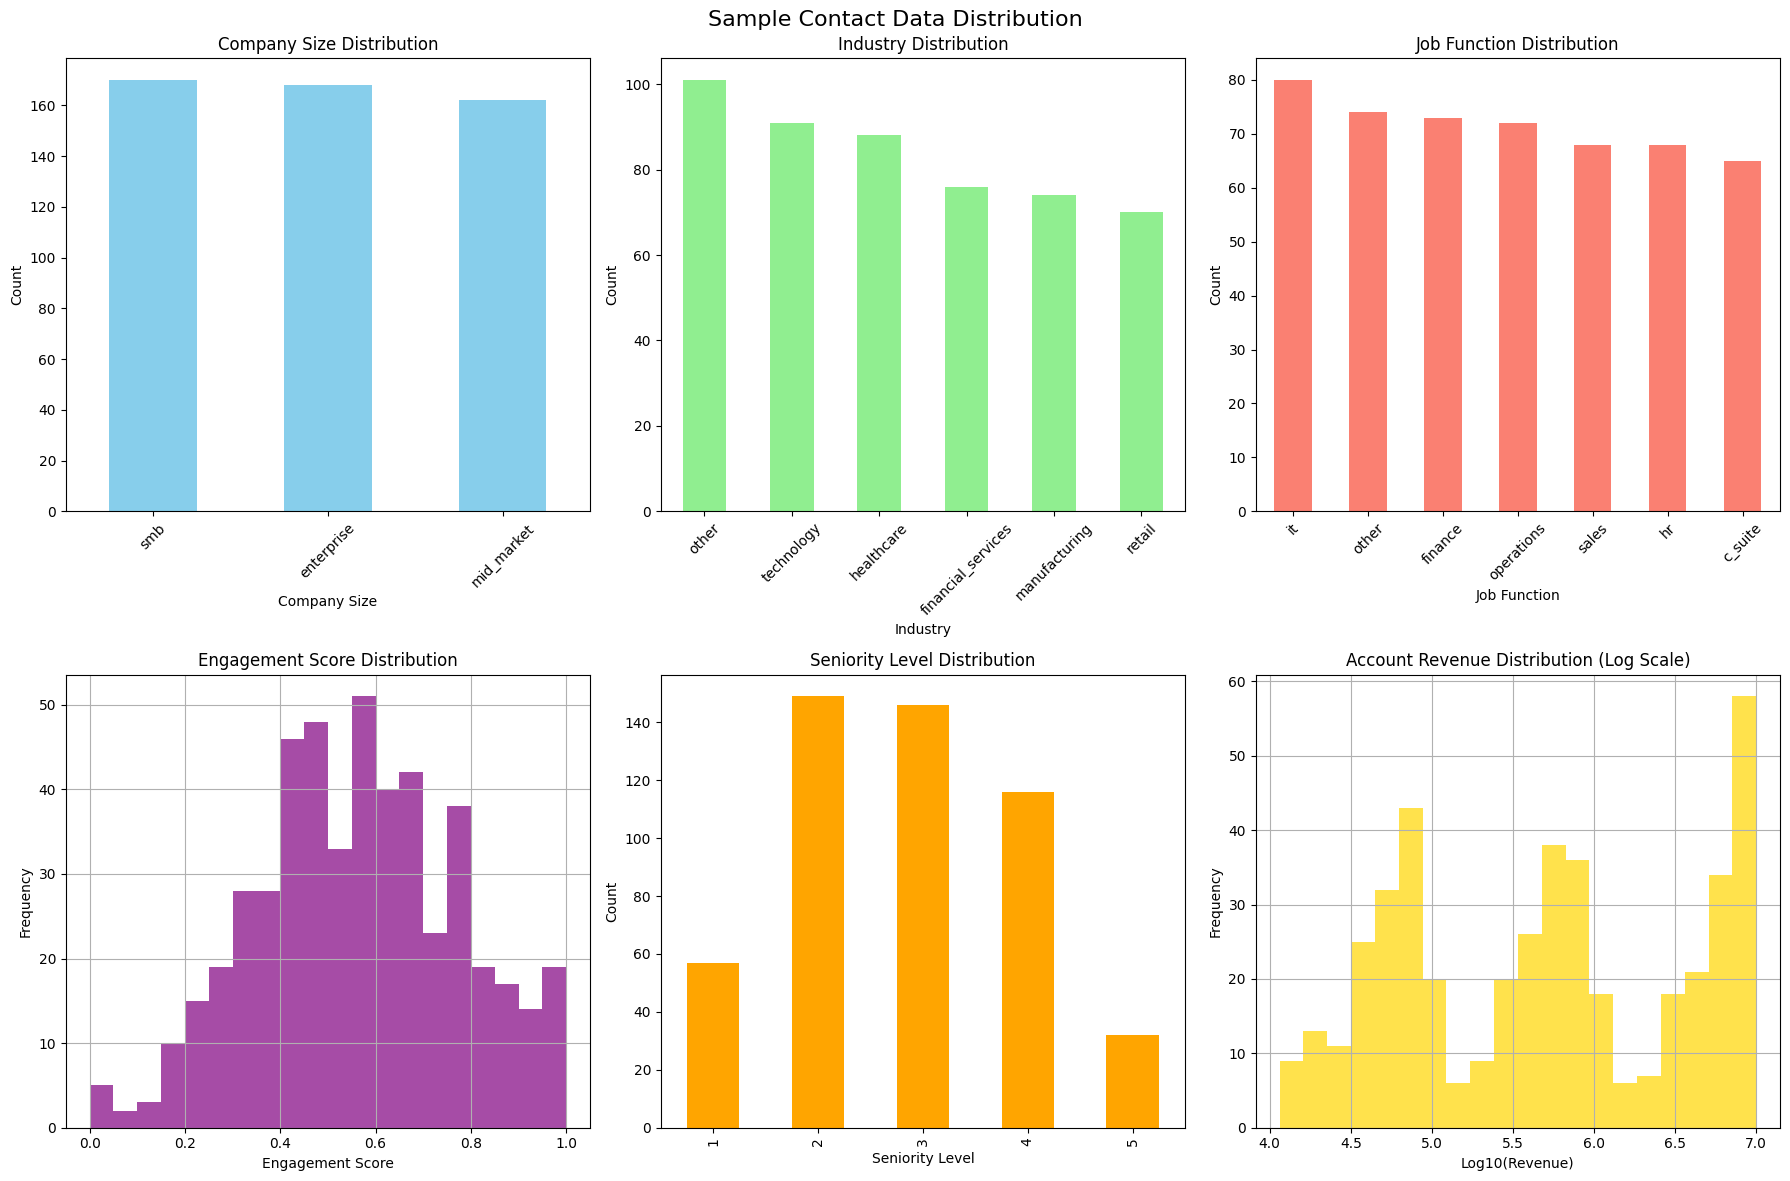

In [5]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Sample Contact Data Distribution', fontsize=16)

# Company size distribution
df['company_size'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Company Size Distribution')
axes[0,0].set_xlabel('Company Size')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Industry distribution
df['industry_vertical'].value_counts().plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Industry Distribution')
axes[0,1].set_xlabel('Industry')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=45)

# Job function distribution
df['job_function'].value_counts().plot(kind='bar', ax=axes[0,2], color='salmon')
axes[0,2].set_title('Job Function Distribution')
axes[0,2].set_xlabel('Job Function')
axes[0,2].set_ylabel('Count')
axes[0,2].tick_params(axis='x', rotation=45)

# Engagement score distribution
df['engagement_score'].hist(bins=20, ax=axes[1,0], color='purple', alpha=0.7)
axes[1,0].set_title('Engagement Score Distribution')
axes[1,0].set_xlabel('Engagement Score')
axes[1,0].set_ylabel('Frequency')

# Seniority level distribution
df['seniority_level'].value_counts().sort_index().plot(kind='bar', ax=axes[1,1], color='orange')
axes[1,1].set_title('Seniority Level Distribution')
axes[1,1].set_xlabel('Seniority Level')
axes[1,1].set_ylabel('Count')

# Revenue distribution (log scale)
revenue_data = df[df['account_revenue'] > 0]['account_revenue']
np.log10(revenue_data).hist(bins=20, ax=axes[1,2], color='gold', alpha=0.7)
axes[1,2].set_title('Account Revenue Distribution (Log Scale)')
axes[1,2].set_xlabel('Log10(Revenue)')
axes[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 3. Train the Segmentation Model

Now let's train our K-Means clustering model on the sample data.

In [6]:
# Initialize and train the model
print("🤖 Initializing segmentation model...")
model = MarketSegmentationModel(n_clusters=8)  # Using 8 clusters for demo

print("🎯 Training model on sample data...")
training_metrics = model.train(sample_contacts)

print("\n📈 Training Results:")
for metric, value in training_metrics.items():
    if isinstance(value, float):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

print(f"\n🎨 Generated {len(model.segment_profiles)} segment profiles")
print("✅ Model training completed!")

🤖 Initializing segmentation model...
🎯 Training model on sample data...

📈 Training Results:
  n_clusters: 8
  silhouette_score: 0.1484
  inertia: 1783.6247
  n_samples: 500

🎨 Generated 8 segment profiles
✅ Model training completed!


## 4. Explore Segment Profiles

Let's examine the characteristics of each discovered segment.

In [7]:
# Display segment profiles
print("🎭 Segment Profiles:")
print("=" * 80)

for segment_id, profile in model.segment_profiles.items():
    print(f"\n📍 {profile.segment_name} (ID: {segment_id})")
    print(f"   📝 Description: {profile.description}")
    print(f"   👥 Size: {profile.size_distribution} contacts")
    print(f"   📊 Avg Engagement: {profile.avg_engagement_score:.1%}")
    print(f"   🏢 Dominant Company Size: {profile.dominant_company_size.value.replace('_', ' ').title()}")
    print(f"   🏭 Dominant Industry: {profile.dominant_industry.value.replace('_', ' ').title()}")
    print(f"   💼 Dominant Job Function: {profile.dominant_job_function.value.replace('_', ' ').title()}")
    print(f"   📢 Messaging Strategy: {profile.messaging_strategy}")
    print("-" * 80)

🎭 Segment Profiles:

📍 Segment 0 (ID: 0)
   📝 Description: Smb companies in Financial Services industry, primarily C Suite roles with 64.7% average engagement
   👥 Size: 59 contacts
   📊 Avg Engagement: 64.7%
   🏢 Dominant Company Size: Smb
   🏭 Dominant Industry: Financial Services
   💼 Dominant Job Function: C Suite
   📢 Messaging Strategy: Moderately engaged - educational content and demos. Senior audience - strategic and executive messaging.
--------------------------------------------------------------------------------

📍 Segment 1 (ID: 1)
   📝 Description: Mid Market companies in Healthcare industry, primarily Other roles with 40.1% average engagement
   👥 Size: 67 contacts
   📊 Avg Engagement: 40.1%
   🏢 Dominant Company Size: Mid Market
   🏭 Dominant Industry: Healthcare
   💼 Dominant Job Function: Other
   📢 Messaging Strategy: Moderately engaged - educational content and demos. Operational audience - practical and tactical messaging.
-----------------------------------------

## 5. Make Predictions

Let's test the prediction functionality with both single and batch predictions.

In [8]:
# Initialize prediction service
print("🔮 Initializing prediction service...")
prediction_service = PredictionService()
prediction_service.model = model  # Use our trained model
prediction_service.is_loaded = True

# Test single prediction
print("\n🎯 Single Prediction Test:")
test_contact = sample_contacts[0]
result = prediction_service.predict_single_contact(test_contact)

print(f"Contact: {test_contact.contact_id}")
print(f"Company: {test_contact.company_size.value} {test_contact.industry_vertical.value}")
print(f"Role: {test_contact.job_function.value} (Level {test_contact.seniority_level})")
print(f"Engagement: {test_contact.engagement_score}")
print(f"\n📊 Prediction Result:")
print(f"Segment ID: {result.segment_id}")
print(f"Segment Name: {result.segment_name}")
print(f"Confidence: {result.confidence_score:.1%}")
print(f"Predicted at: {result.predicted_at}")

# Get recommendations for this segment
recommendations = prediction_service.get_segment_recommendations(result.segment_id)
print(f"\n💡 Marketing Recommendations:")
print(f"Content: {recommendations.get('content_recommendations', [])[:2]}")
print(f"Channels: {recommendations.get('channel_recommendations', [])[:2]}")
print(f"Timing: {recommendations.get('timing_recommendations', [])[:2]}")

🔮 Initializing prediction service...

🎯 Single Prediction Test:
Contact: demo_contact_0000
Company: enterprise manufacturing
Role: sales (Level 3)
Engagement: 0.655

📊 Prediction Result:
Segment ID: 5
Segment Name: Segment 5
Confidence: 46.2%
Predicted at: 2025-08-06 14:07:16.587962

💡 Marketing Recommendations:
Content: ['Mid-market growth stories and expansion strategies', 'Revenue impact and sales enablement tools']
Channels: ['Sales-focused events', 'Revenue operations communities']
Timing: ['Follow-up within 3-5 business days', 'Flexible scheduling, avoid Monday mornings and Friday afternoons']


In [9]:
# Test batch prediction
print("🚀 Batch Prediction Test:")
batch_contacts = sample_contacts[10:20]  # Use 10 contacts for testing
batch_request = BatchSegmentRequest(contacts=batch_contacts)

batch_result = prediction_service.predict_batch_contacts(batch_request)

print(f"Processed: {batch_result.total_processed} contacts")
print(f"Processing time: {batch_result.processing_time_seconds:.3f} seconds")
print(f"Average time per contact: {(batch_result.processing_time_seconds / batch_result.total_processed * 1000):.2f} ms")

print("\n📋 Batch Results Summary:")
segment_counts = {}
total_confidence = 0

for result in batch_result.results:
    segment_counts[result.segment_id] = segment_counts.get(result.segment_id, 0) + 1
    total_confidence += result.confidence_score

print(f"Segment distribution: {dict(sorted(segment_counts.items()))}")
print(f"Average confidence: {(total_confidence / len(batch_result.results)):.1%}")

🚀 Batch Prediction Test:
Processed: 10 contacts
Processing time: 0.040 seconds
Average time per contact: 3.95 ms

📋 Batch Results Summary:
Segment distribution: {1: 4, 2: 1, 4: 1, 5: 2, 6: 2}
Average confidence: 56.5%


## 6. Analyze Segmentation Results

Let's analyze the complete segmentation results to understand our customer base.

In [11]:
# Predict segments for all contacts
print("🔍 Analyzing complete segmentation results...")
all_predictions = model.predict(sample_contacts)

# Add predictions to DataFrame
df['segment_id'] = all_predictions
df['segment_name'] = df['segment_id'].apply(lambda x: model.segment_profiles[x].segment_name if x in model.segment_profiles else f'Segment {x}')

# Calculate confidence scores for analysis
confidence_scores = []
for contact in sample_contacts:
    confidence = model.calculate_confidence_score(contact)
    confidence_scores.append(confidence)

df['confidence_score'] = confidence_scores

print("📊 Segmentation Summary:")
segment_summary = df.groupby(['segment_id', 'segment_name']).agg({
    'contact_id': 'count',
    'engagement_score': 'mean',
    'confidence_score': 'mean',
    'account_revenue': 'mean'
}).round(3)

segment_summary.columns = ['Count', 'Avg_Engagement', 'Avg_Confidence', 'Avg_Revenue']
print(segment_summary)

🔍 Analyzing complete segmentation results...
📊 Segmentation Summary:
                         Count  Avg_Engagement  Avg_Confidence  Avg_Revenue
segment_id segment_name                                                    
0          Segment 0        59           0.647           0.566   207653.938
1          Segment 1        67           0.401           0.572   691190.625
2          Segment 2        76           0.522           0.520  6672112.338
3          Segment 3        45           0.575           0.536  1041748.468
4          Segment 4        57           0.700           0.607   185554.901
5          Segment 5        63           0.687           0.564   721697.115
6          Segment 6        94           0.418           0.622   228377.941
7          Segment 7        39           0.733           0.586  7417948.574


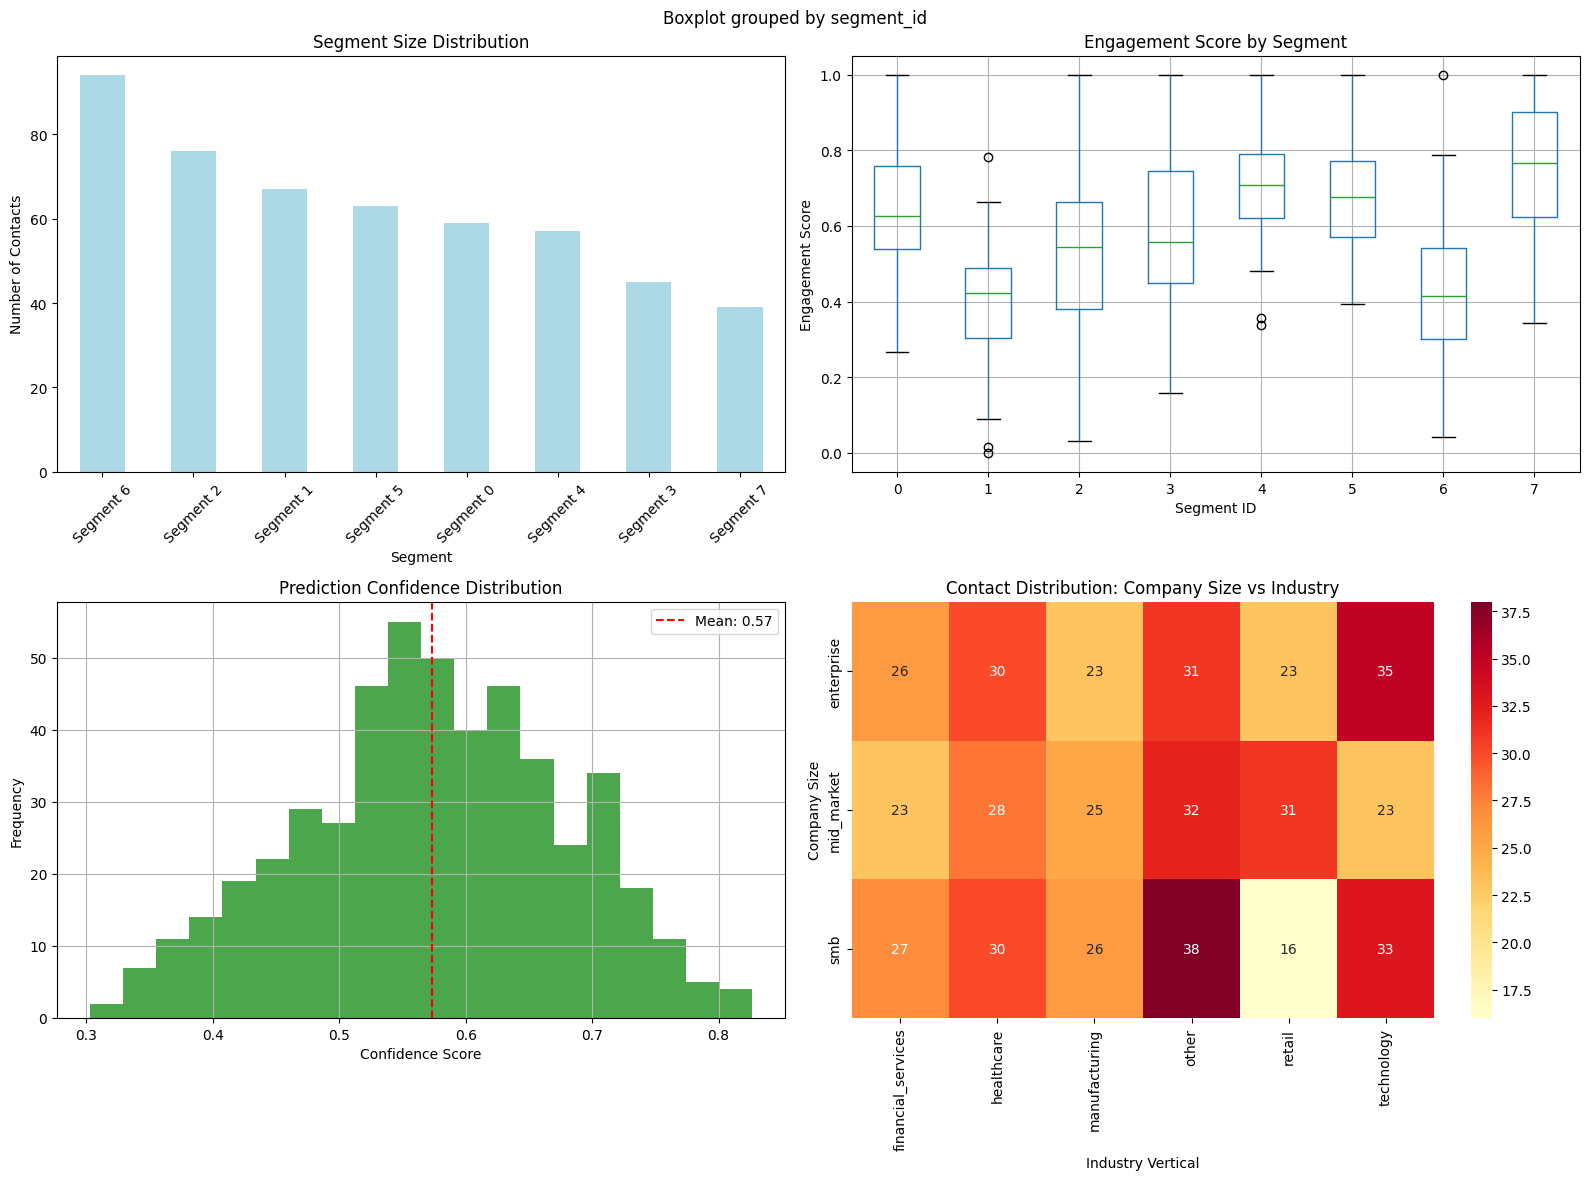

In [12]:
# Create visualization of segments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Market Segmentation Analysis', fontsize=16)

# Segment size distribution
segment_counts = df['segment_name'].value_counts()
segment_counts.plot(kind='bar', ax=axes[0,0], color='lightblue')
axes[0,0].set_title('Segment Size Distribution')
axes[0,0].set_xlabel('Segment')
axes[0,0].set_ylabel('Number of Contacts')
axes[0,0].tick_params(axis='x', rotation=45)

# Engagement by segment
df.boxplot(column='engagement_score', by='segment_id', ax=axes[0,1])
axes[0,1].set_title('Engagement Score by Segment')
axes[0,1].set_xlabel('Segment ID')
axes[0,1].set_ylabel('Engagement Score')

# Confidence score distribution
df['confidence_score'].hist(bins=20, ax=axes[1,0], color='green', alpha=0.7)
axes[1,0].set_title('Prediction Confidence Distribution')
axes[1,0].set_xlabel('Confidence Score')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(df['confidence_score'].mean(), color='red', linestyle='--', label=f'Mean: {df["confidence_score"].mean():.2f}')
axes[1,0].legend()

# Company size vs Industry heatmap by segment
pivot_data = df.pivot_table(values='contact_id', index='company_size', columns='industry_vertical', aggfunc='count', fill_value=0)
sns.heatmap(pivot_data, annot=True, fmt='d', ax=axes[1,1], cmap='YlOrRd')
axes[1,1].set_title('Contact Distribution: Company Size vs Industry')
axes[1,1].set_xlabel('Industry Vertical')
axes[1,1].set_ylabel('Company Size')

plt.tight_layout()
plt.show()

## 7. Save and Load Model

Let's demonstrate saving and loading the trained model.

In [13]:
# Save the model
print("💾 Saving trained model...")
model_path = model.save_model()
print(f"✅ Model saved to: {model_path}")

# Test loading the model
print("\n📂 Testing model loading...")
new_model = MarketSegmentationModel()
new_model.load_model(model_path)

# Verify the loaded model works
test_contact = sample_contacts[5]
original_prediction = model.predict_single(test_contact)
loaded_prediction = new_model.predict_single(test_contact)

print(f"Original model prediction: {original_prediction}")
print(f"Loaded model prediction: {loaded_prediction}")
print(f"✅ Predictions match: {original_prediction == loaded_prediction}")

print(f"\n📈 Model info:")
print(f"Clusters: {new_model.n_clusters}")
print(f"Features: {len(new_model.feature_names)}")
print(f"Segment profiles: {len(new_model.segment_profiles)}")

💾 Saving trained model...
✅ Model saved to: models/segmentation_model.joblib

📂 Testing model loading...
Original model prediction: 7
Loaded model prediction: 7
✅ Predictions match: True

📈 Model info:
Clusters: 8
Features: 7
Segment profiles: 8


## 8. API Usage Example

Here's how to use the FastAPI endpoints (assuming the API is running).

In [14]:
# API usage example (requires running API server)
import requests
import json

# Note: This assumes the API is running on localhost:8000
# Start the API with: uvicorn src.api.main:app --reload

API_BASE_URL = "http://localhost:8000"

def test_api_endpoints():
    """Test API endpoints if server is running."""
    try:
        # Test health endpoint
        response = requests.get(f"{API_BASE_URL}/health", timeout=2)
        if response.status_code == 200:
            print("✅ API Health Check:")
            print(json.dumps(response.json(), indent=2))
            
            # Test single prediction
            test_contact_data = {
                "contact_id": "api_test_001",
                "company_size": "smb",
                "industry_vertical": "technology",
                "job_function": "it",
                "seniority_level": 3,
                "geographic_region": "North America",
                "engagement_score": 0.75,
                "account_revenue": 50000.0
            }
            
            print("\n🎯 Testing single prediction:")
            response = requests.post(f"{API_BASE_URL}/predict", json=test_contact_data)
            if response.status_code == 200:
                print("✅ Prediction successful:")
                print(json.dumps(response.json(), indent=2))
            else:
                print(f"❌ Prediction failed: {response.status_code}")
                print(response.text)
                
        else:
            print(f"❌ API not available: {response.status_code}")
            
    except requests.exceptions.RequestException:
        print("⚠️  API server not running. To test API endpoints:")
        print("   1. Save the trained model (done above)")
        print("   2. Run: uvicorn src.api.main:app --reload")
        print("   3. Visit: http://localhost:8000/docs")
        print("   4. Re-run this cell")

test_api_endpoints()

⚠️  API server not running. To test API endpoints:
   1. Save the trained model (done above)
   2. Run: uvicorn src.api.main:app --reload
   3. Visit: http://localhost:8000/docs
   4. Re-run this cell


## 9. Business Insights

Let's extract actionable business insights from our segmentation.

In [15]:
# Generate business insights
print("🔍 Business Insights from Segmentation:")
print("=" * 60)

# Top segments by size
top_segments = df['segment_name'].value_counts().head(3)
print("\n📊 Top 3 Largest Segments:")
for i, (segment, count) in enumerate(top_segments.items(), 1):
    percentage = (count / len(df)) * 100
    print(f"  {i}. {segment}: {count} contacts ({percentage:.1f}%)")

# High-value segments (by revenue)
high_value_segments = df[df['account_revenue'] > 0].groupby('segment_name')['account_revenue'].mean().sort_values(ascending=False).head(3)
print("\n💰 Top 3 High-Value Segments (by revenue):")
for i, (segment, avg_revenue) in enumerate(high_value_segments.items(), 1):
    print(f"  {i}. {segment}: ${avg_revenue:,.0f} average revenue")

# High-engagement segments
high_engagement_segments = df.groupby('segment_name')['engagement_score'].mean().sort_values(ascending=False).head(3)
print("\n🔥 Top 3 High-Engagement Segments:")
for i, (segment, avg_engagement) in enumerate(high_engagement_segments.items(), 1):
    print(f"  {i}. {segment}: {avg_engagement:.1%} average engagement")

# Recommendations by segment type
print("\n💡 Strategic Recommendations:")

# Enterprise vs SMB insights
enterprise_segments = df[df['company_size'] == 'enterprise']['segment_name'].value_counts()
smb_segments = df[df['company_size'] == 'smb']['segment_name'].value_counts()

print(f"\n🏢 Enterprise Focus:")
if len(enterprise_segments) > 0:
    top_enterprise = enterprise_segments.index[0]
    print(f"  • Primary enterprise segment: {top_enterprise}")
    print(f"  • Recommendation: Develop enterprise-specific content and account-based marketing")

print(f"\n🏪 SMB Focus:")
if len(smb_segments) > 0:
    top_smb = smb_segments.index[0]
    print(f"  • Primary SMB segment: {top_smb}")
    print(f"  • Recommendation: Focus on self-service solutions and cost-effective messaging")

# Low confidence predictions need attention
low_confidence_contacts = df[df['confidence_score'] < 0.5]
print(f"\n⚠️  Quality Alert:")
print(f"  • {len(low_confidence_contacts)} contacts ({len(low_confidence_contacts)/len(df)*100:.1f}%) have low prediction confidence")
print(f"  • Recommendation: Collect additional data points for these contacts")

print("\n" + "=" * 60)
print("✅ Market Segmentation Analysis Complete!")
print(f"📈 Model Performance: {df['confidence_score'].mean():.1%} average confidence")
print(f"🎯 Ready for production use with {len(model.segment_profiles)} distinct segments")

🔍 Business Insights from Segmentation:

📊 Top 3 Largest Segments:
  1. Segment 6: 94 contacts (18.8%)
  2. Segment 2: 76 contacts (15.2%)
  3. Segment 1: 67 contacts (13.4%)

💰 Top 3 High-Value Segments (by revenue):
  1. Segment 7: $7,417,949 average revenue
  2. Segment 2: $6,672,112 average revenue
  3. Segment 3: $1,171,967 average revenue

🔥 Top 3 High-Engagement Segments:
  1. Segment 7: 73.3% average engagement
  2. Segment 4: 70.0% average engagement
  3. Segment 5: 68.7% average engagement

💡 Strategic Recommendations:

🏢 Enterprise Focus:
  • Primary enterprise segment: Segment 2
  • Recommendation: Develop enterprise-specific content and account-based marketing

🏪 SMB Focus:
  • Primary SMB segment: Segment 6
  • Recommendation: Focus on self-service solutions and cost-effective messaging

⚠️  Quality Alert:
  • 115 contacts (23.0%) have low prediction confidence
  • Recommendation: Collect additional data points for these contacts

✅ Market Segmentation Analysis Complete!
📈

## Summary

This notebook demonstrated the complete Market Segmentation POC workflow:

1. **Data Generation**: Created realistic sample contact data
2. **Model Training**: Trained K-Means clustering model with 8 segments
3. **Predictions**: Made both single and batch predictions
4. **Analysis**: Analyzed segment characteristics and business insights
5. **Persistence**: Saved and loaded the trained model
6. **API Integration**: Showed how to use the FastAPI endpoints
7. **Business Value**: Extracted actionable insights for marketing strategy

### Next Steps:
- Deploy the API to a cloud environment
- Integrate with real CRM data
- Set up automated model retraining
- Build a dashboard for business users
- Implement A/B testing for segment-based campaigns